<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#개요" data-toc-modified-id="개요-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>개요</a></span><ul class="toc-item"><li><span><a href="#주제:-Allstate-Claims-Severity" data-toc-modified-id="주제:-Allstate-Claims-Severity-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>주제: Allstate Claims Severity</a></span></li><li><span><a href="#데이터-설명" data-toc-modified-id="데이터-설명-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>데이터 설명</a></span></li></ul></li><li><span><a href="#탐색적-분석" data-toc-modified-id="탐색적-분석-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>탐색적 분석</a></span><ul class="toc-item"><li><span><a href="#cat변수-시각화" data-toc-modified-id="cat변수-시각화-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>cat변수 시각화</a></span></li><li><span><a href="#cot-변수-시각화" data-toc-modified-id="cot-변수-시각화-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>cot 변수 시각화</a></span></li><li><span><a href="#loss-시각화" data-toc-modified-id="loss-시각화-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>loss 시각화</a></span></li></ul></li><li><span><a href="#데이터-전처리" data-toc-modified-id="데이터-전처리-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리</a></span><ul class="toc-item"><li><span><a href="#cat변수-K-Means로-군집화" data-toc-modified-id="cat변수-K-Means로-군집화-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>cat변수 K-Means로 군집화</a></span></li></ul></li></ul></div>

### 개요
#### 주제: Allstate Claims Severity
https://www.kaggle.com/c/allstate-claims-severity<br>
보험금 청구비용(loss) 예측 모델을 구축한다.

#### 데이터 설명
: 미국의 개인 보험 회사 Allstate 계약(id)별 보험금 청구액(loss)관련 자료이다.<br>
컬럼명 cat1,2,3... cont1,2,3... 은 아래와 같이 의미한다. 'cat' - categorical(명목형 변수)<br>
'cont' - continuous (연속형 변수)<br>

cat 데이터는 A,B,C...., LB,DC,CQ...등 유형을 나타내도록 변환되었고, cont 데이터는 0~1 소숫점으로 변환되어 주어진 상태이다.

In [74]:
#!pip install xgboost
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from util import Dataset

for name in ['train', 'test']:
    print "Processing %s..." % name
    data = pd.read_csv('../input/%s.csv.zip' % name)

    # Save column names
    if name == 'train':
        cat_columns = [c for c in data.columns if c.startswith('cat')]
        num_columns = [c for c in data.columns if c.startswith('cont')]

        Dataset.save_part_features('categorical', cat_columns)
        Dataset.save_part_features('numeric', num_columns)

    Dataset(categorical=data[cat_columns].values).save(name)
    Dataset(numeric=data[num_columns].values.astype(np.float32)).save(name)
    Dataset(id=data['id']).save(name)

    if 'loss' in data.columns:
        Dataset(loss=data['loss']).save(name)


print "Done."

### 탐색적 분석

In [3]:
train = pd.read_csv('train.csv')
train.shape

(188318, 132)

In [43]:
X = train.iloc[:,1:-1]
y = train.loss
print(X.shape)
print(y.shape)

(188318, 130)
(188318,)


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 130 entries, cat1 to cont14
dtypes: float64(14), object(116)
memory usage: 186.8+ MB


In [6]:
X.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,D,D,B,D,C,B,D,B,A,A,A,A,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,A,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,B,D,B,D,C,B,B,B,A,A,A,A,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,D,D,D,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,B,D,B,B,C,B,B,C,A,A,A,B,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606


In [7]:
X.describe(include = ['object'])

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
count,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,8,7,8,7,5,7,5,8,7,5,16,15,19,9,13,17,20,17,20,11,84,131,16,51,61,19,23,326
top,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,D,C,E,C,A,P,F,A,A,A,E,E,G,F,B,BI,CL,A,E,BM,A,K,HK
freq,141550,106721,177993,128395,123737,131693,183744,177274,113122,160213,168186,159825,168851,186041,188284,181843,187009,187331,186510,188114,187905,188275,157445,181977,169969,177119,168250,180938,184593,184760,182980,187107,187361,187734,188105,156313,165729,169323,183393,180119,181177,186623,184110,172716,183991,187436,187617,188049,179127,137611,187071,179505,172949,183762,188173,188136,185296,188079,188018,187872,187596,188273,188239,188271,186056,179982,187626,188176,188011,188295,178646,118322,154275,184731,154307,181347,187503,186526,152929,137505,154385,147536,141534,154939,186005,103852,166992,168926,183744,177993,111028,124689,150237,121642,87531,174360,78127,105492,79455,42970,106721,177274,123737,42925,76493,47165,47310,65512,152918,25305,128395,25148,26191,131693,43866,21061


In [8]:
X.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848


In [9]:
# cout와 cat 변수명 리스트로 담기
cont_columns = []
cat_columns = []

for i in X.columns:
    if X[i].dtype == 'float':
        cont_columns.append(i)
    elif X[i].dtype == 'object':
        cat_columns.append(i)

#### cat변수 시각화

In [ ]:
cols = train.columns

# 29x4 형태로 시각화

n_cols = 4
n_rows = 29
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,sharey=True,figsize=(18, 8))
    for j in range(n_cols):
        sns.distplot(x=cols[i*n_cols+j], data=train, ax=ax[j])

#### cot 변수 시각화

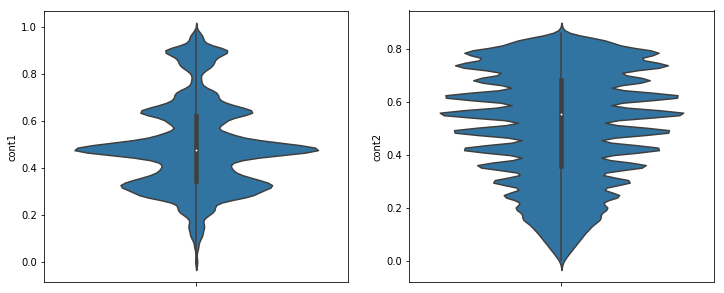

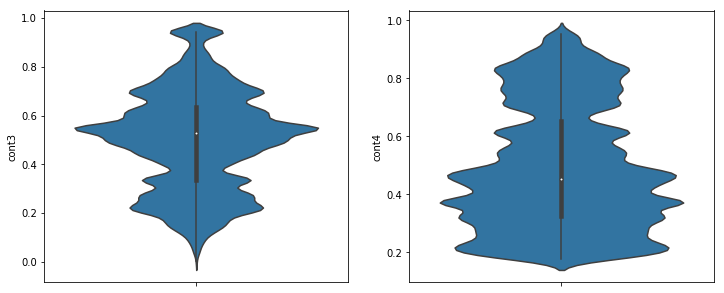

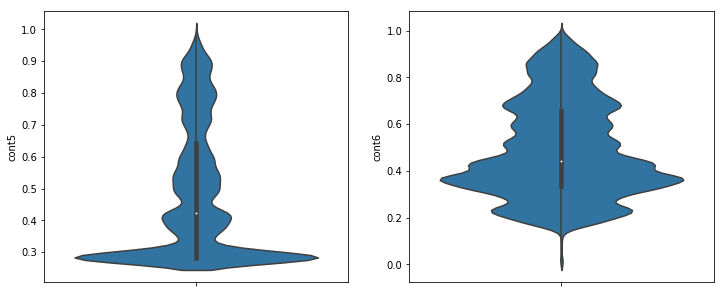

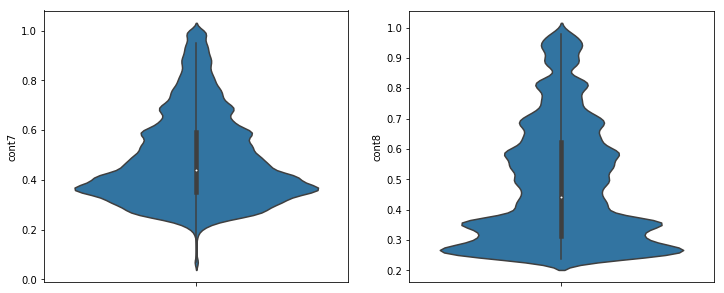

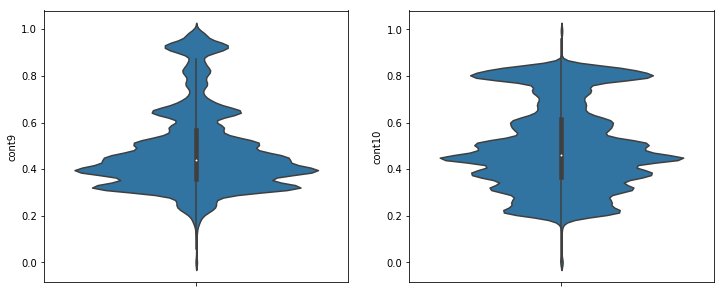

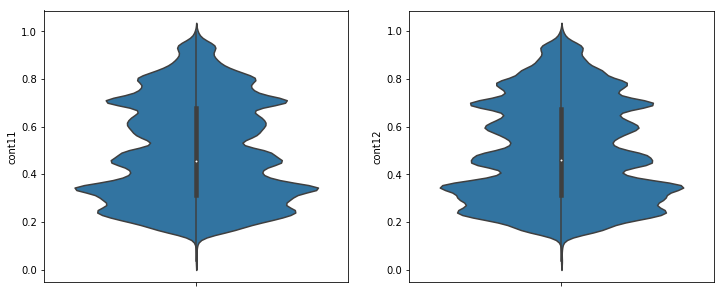

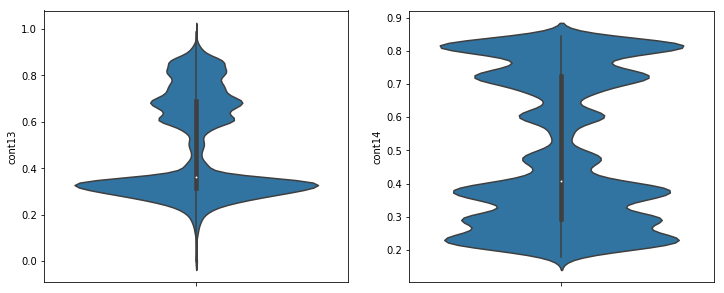

In [26]:
cols=X[cont_columns].columns 
n_cols = 2
n_rows = 7

for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(12, 5))
    for j in range(n_cols):
        sns.violinplot(cols[i*n_cols+j], data=X, ax=ax[j], orient='v')

#### loss 시각화

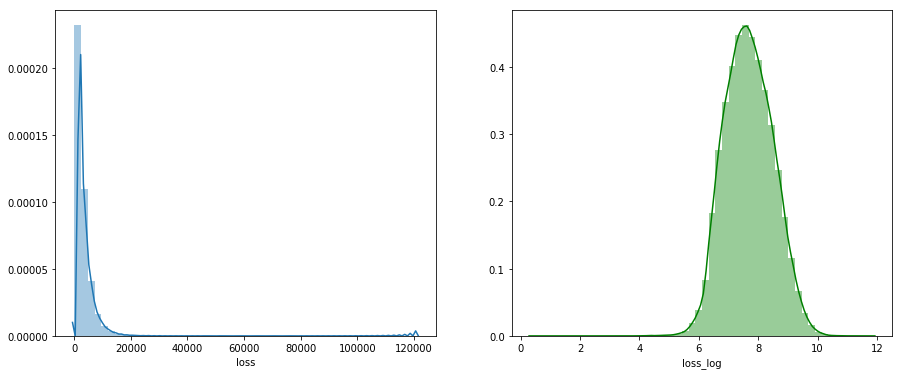

In [72]:
# loss가 좌편향되어 있어 log를 취함
train['loss_log'] = np.log1p(train['loss'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 6)
sns.distplot(train.loss, ax=ax1)
sns.distplot(train.loss_log, ax=ax2, color="green")
plt.show()

In [ ]:
# log transform the label variable

In [ ]:
#sns.pairplot(train[cont_columns], kind = 'scatter',diag_kind='kde')

In [73]:
round(train[cont_columns].corr(),2).style.background_gradient(cmap='coolwarm')

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
cont1,1,-0.09,-0.45,0.37,-0.03,0.76,0.37,0.36,0.93,0.81,0.6,0.61,0.53,0.06
cont2,-0.09,1,0.46,0.04,0.19,0.02,0.05,0.14,-0.03,0.06,0.12,0.11,0.02,-0.05
cont3,-0.45,0.46,1,-0.34,0.09,-0.35,0.1,-0.19,-0.42,-0.33,0.03,0.01,-0.42,-0.04
cont4,0.37,0.04,-0.34,1,0.16,0.22,-0.12,0.53,0.33,0.28,0.12,0.13,0.18,0.02
cont5,-0.03,0.19,0.09,0.16,1,-0.15,-0.25,0.01,-0.09,-0.06,-0.15,-0.15,-0.08,-0.02
cont6,0.76,0.02,-0.35,0.22,-0.15,1,0.66,0.44,0.8,0.88,0.77,0.79,0.82,0.04
cont7,0.37,0.05,0.1,-0.12,-0.25,0.66,1,0.14,0.38,0.49,0.75,0.74,0.29,0.02
cont8,0.36,0.14,-0.19,0.53,0.01,0.44,0.14,1,0.45,0.34,0.3,0.32,0.48,0.04
cont9,0.93,-0.03,-0.42,0.33,-0.09,0.8,0.38,0.45,1,0.79,0.61,0.63,0.64,0.07
cont10,0.81,0.06,-0.33,0.28,-0.06,0.88,0.49,0.34,0.79,1,0.7,0.71,0.71,0.04


### 데이터 전처리
#### cat변수 K-Means로 군집화
- kmeans로 cat를 군집화하여 변수를 줄인다.

In [ ]:

le=LabelEncoder()
cols = X[cat_columns].columns
for col in cols:
    X[col]=le.fit_transform(X[col])

X[cat_columns].head()

In [ ]:
X_cat = X[cat_columns]

cluster_range = range( 1, 20 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( X_cat )
  cluster_errors.append( clusters.inertia_ )

clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

# Kmeans cluster_errors의 최적화 시각화
plt.figure(figsize=(12,6), )
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o", )
plt.title("The Elbow Method showing the optimal k")
plt.show()

kmeans = KMeans(n_clusters=3)
kmeans.fit( X_cat )
res = pd.Series(kmeans.labels_)

In [76]:
res

0         0
1         1
2         2
3         1
4         1
5         1
6         1
7         0
8         2
9         0
10        2
11        2
12        1
13        1
14        0
15        1
16        1
17        0
18        2
19        2
20        1
21        2
22        1
23        1
24        2
25        2
26        2
27        1
28        2
29        2
         ..
188288    2
188289    2
188290    2
188291    2
188292    2
188293    0
188294    1
188295    2
188296    2
188297    2
188298    2
188299    2
188300    2
188301    2
188302    1
188303    0
188304    2
188305    2
188306    0
188307    2
188308    1
188309    1
188310    1
188311    2
188312    1
188313    1
188314    1
188315    1
188316    0
188317    0
Length: 188318, dtype: int32